## TestModelOverClusters_ControlledForSampleSize

This script evaluates how predictive performance varies with sample size and number of clusters, while controlling for unequal image counts across clusters.

*Data*  
- Reads the expanded dataframe (one row per image) with cluster assignments for k=2..10 (output of script 5)
- Reads IMD data (for use in model fitting)
- Loads the best XGBoost model from script 4

*Subsampling*  
For each value of k (2 to 10):
- The dataframe is grouped by the corresponding cluster label (scene_cluster_k).
- For each requested sample size N [500, 1000, 2000, ..., 20000]:
    - Up to N images are randomly sampled from each cluster independently.
    - If a cluster contains fewer than N images, all available images are used (i.e. the sample is capped).
    - The effective number of samples per cluster is recorded for later diagnostics.

This subsampling procedure is repeated 10 times using different random seeds to capture sampling variability.

*Feature construction*  
For each subsampled dataset:
- Images are grouped by LSOA.
- Within each LSOA and cluster, the median embedding is computed.
- These per-cluster median embeddings are merged into a single modelling table.
- IMD rank is joined and re-ranked to produce a continuous prediction target.

*Model fitting*  
For each combination of k, subsample size N, random repeat, and individual cluster:
- If a cluster was capped (i.e. contains fewer than N images), model fitting for that cluster is skipped.
- LSOAs with missing embeddings are removed.
- A random train-test split (80/20) is applied.
- An XGBoost model is trained to predict IMD rank using only the median embedding from the given cluster.
- R2, RMSE, and MAE are recorded.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from joblib import Parallel, delayed
import joblib


def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

def median_embed(series):
    return np.median(np.stack(series.values), axis=0)

In [2]:
from directory_filepaths import *

In [3]:
# Number of clusters 
k=4

In [4]:
# Specify the size of subsamples we wish to make
sample_sizes = [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]

### Load best model from the model testing
Clone it so it doesn't have parameters fitted already

In [5]:
best_model = joblib.load(os.path.join(data_dir, "best_model/best_model.joblib"))['model']
model = clone(best_model)

### Get data

In [6]:
# Load expanded dataframe with cluster assignments (output of script 5)
expanded_gdf = pd.read_pickle(os.path.join(data_dir, "one_row_per_image_cleaned_with_cluster_numbers.pkl"))
print(f"Loaded {len(expanded_gdf)} image rows")

Loaded 75586 image rows


In [7]:
# for num in range(1,8):
#     print(num)
#     print(len(expanded_gdf[expanded_gdf['scene_cluster_7']==num]))

In [8]:
# final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
# file_ending = f'kmeanscluster{k}_resampled1'
# final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_{file_ending}.pkl")

### Read in IMD data

In [9]:
# imd_file is imported from directory_filepaths
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

imd = imd.rename(columns={
    "LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile",
})

# Test model performance 


In [10]:
def sub_sample_data(df, cluster_col, n_per_cluster, random_state=None):
    """
    Sample up to n_per_cluster rows from each cluster.
    If a cluster has fewer rows, all are used (capped).
    """
    sampled = []
    for _, group in df.groupby(cluster_col):
        sampled.append(group.sample(n=min(len(group), n_per_cluster), random_state=random_state))
    return pd.concat(sampled).reset_index(drop=True)


def fit_models_for_k_sample(
    k, sample_size, repeat_id, expanded_gdf, imd, base_model, base_seed=42
):
    """
    For a given k and sample_size, subsample images, compute median embeddings
    per LSOA per cluster, and fit an XGBoost model for each cluster.
    """
    random_state = base_seed + repeat_id
    cluster_col = f"scene_cluster_{k}"
    categories = range(1, k + 1)

    # Cluster sizes in the full dataset
    cluster_sizes = expanded_gdf[cluster_col].value_counts()

    # Balanced subsample
    df = sub_sample_data(
        expanded_gdf, cluster_col,
        n_per_cluster=sample_size, random_state=random_state,
    )

    # Record actual sample counts and whether each cluster was capped
    actual_counts = df[cluster_col].value_counts().reindex(categories, fill_value=0).to_dict()
    sampling_status = {
        c: "full" if cluster_sizes.get(c, 0) >= sample_size else "capped"
        for c in categories
    }

    # Median embedding per LSOA, for each cluster
    per_cluster_dfs = [
        df[df[cluster_col] == cat]
        .groupby("LSOA21CD")["embedding"]
        .apply(median_embed)
        .reset_index()
        .rename(columns={"embedding": f"{cat}_median"})
        for cat in categories
    ]

    final_df = reduce(
        lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
        per_cluster_dfs,
    )

    # Join IMD and re-rank locally
    final_df = final_df.merge(imd[["LSOA21CD", "imd_rank"]], on="LSOA21CD", how="left")
    final_df["imd_rerank"] = final_df["imd_rank"].rank(method="first").astype(int)

    # Fit one model per cluster
    r2_results = {}
    mae_results = {}
    rmse_results = {}
    effective_n = {}

    for cluster_num in categories:
        # Skip capped clusters (not enough data for fair comparison)
        if sampling_status[cluster_num] == "capped":
            r2_results[cluster_num] = np.nan
            mae_results[cluster_num] = np.nan
            rmse_results[cluster_num] = np.nan
            effective_n[cluster_num] = actual_counts[cluster_num]
            continue

        col = f"{cluster_num}_median"
        df_cluster = final_df[["LSOA21CD", col, "imd_rerank"]].copy()
        df_cluster = df_cluster[~df_cluster[col].apply(is_missing_embedding)]

        effective_n[cluster_num] = len(df_cluster)

        if len(df_cluster) < 5:
            r2_results[cluster_num] = np.nan
            mae_results[cluster_num] = np.nan
            rmse_results[cluster_num] = np.nan
            continue

        X = np.stack(df_cluster[col].values)
        y = df_cluster["imd_rerank"].values
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state,
        )

        # Clone the base model so each fit starts fresh
        this_model = clone(base_model)
        this_model.fit(X_train, y_train)
        y_pred = this_model.predict(X_test)

        r2_results[cluster_num] = r2_score(y_test, y_pred)
        rmse_results[cluster_num] = np.sqrt(mean_squared_error(y_test, y_pred))
        mae_results[cluster_num] = mean_absolute_error(y_test, y_pred)

    return {
        "k": k,
        "sample_size": sample_size,
        "repeat": repeat_id,
        "r2_results": r2_results,
        "rmse_results": rmse_results,
        "mae_results": mae_results,
        "actual_sample_counts": actual_counts,
        "effective_n_after_filtering": effective_n,
        "sampling_status": sampling_status,
    }


results_path = os.path.join(data_dir, "model_testing", "cluster_subsample_results.pkl")

if os.path.exists(results_path):
    print(f"Results already exist at {results_path}, skipping computation. Delete the file to re-run.")
    outputs = pd.read_pickle(results_path)
else:
    # Only pass the columns workers actually need (saves ~1GB of spatial/metadata columns per worker)
    cluster_cols = [f"scene_cluster_{k}" for k in range(2, 11)]
    slim_gdf = expanded_gdf[["LSOA21CD", "embedding"] + cluster_cols].copy()

    n_repeats = 10
    n_jobs = 8
    k_values = range(2, 11)

    outputs = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(fit_models_for_k_sample)(
            k, sample_size, repeat_id, slim_gdf, imd, model,
        )
        for k in k_values
        for sample_size in sample_sizes
        for repeat_id in range(n_repeats)
    )

Results already exist at ../../../../data/embeddings/model_testing/cluster_subsample_results.pkl, skipping computation. Delete the file to re-run.


### Format outputs

Output structure

The script returns, for every experiment run:

 - the number of clusters k, the target sample size N, the repeat index, the effective sample counts per cluster, per-cluster model performance (R2)

Results are subsequently aggregated across repeats to compute:
- median R2  as a function of sample size
- variability due to random subsampling
- convergence behaviour of predictive performance with increasing data availability.

In [11]:
# Save results (only needed after fresh computation; harmless to re-run)
os.makedirs(os.path.dirname(results_path), exist_ok=True)
pd.to_pickle(outputs, results_path)
print(f"Saved {len(outputs)} results to {results_path}")

Saved 1080 results to ../../../../data/embeddings/model_testing/cluster_subsample_results.pkl


In [12]:
# Reload results from disk (useful if kernel was restarted after the cell above)
# outputs = pd.read_pickle(results_path)

In [13]:
### Convert results to a tidy dataframe
rows = []

for run in outputs:
    k = run["k"]
    sample_size = run["sample_size"]
    repeat = run["repeat"]

    r2_dict   = run["r2_results"]
    rmse_dict = run["rmse_results"]
    mae_dict  = run["mae_results"]

    for cluster_num in r2_dict.keys():
        rows.append({"k": k, "sample_size": sample_size,
            "repeat": repeat, "cluster": cluster_num,
            "r2": r2_dict.get(cluster_num, np.nan),
            "rmse": rmse_dict.get(cluster_num, np.nan),
            "mae": mae_dict.get(cluster_num, np.nan)})

results_df = pd.DataFrame(rows)

In [14]:
### Summarise results over samples
summary = (results_df.groupby(["k", "sample_size", "cluster"]).agg(mean_r2   = ("r2", "mean"),
        std_r2    = ("r2", "std"),

        mean_rmse = ("rmse", "mean"),
        std_rmse  = ("rmse", "std"),

        mean_mae  = ("mae", "mean"),
        std_mae   = ("mae", "std"),

        n=("r2", "count")).reset_index())

### Plot the results

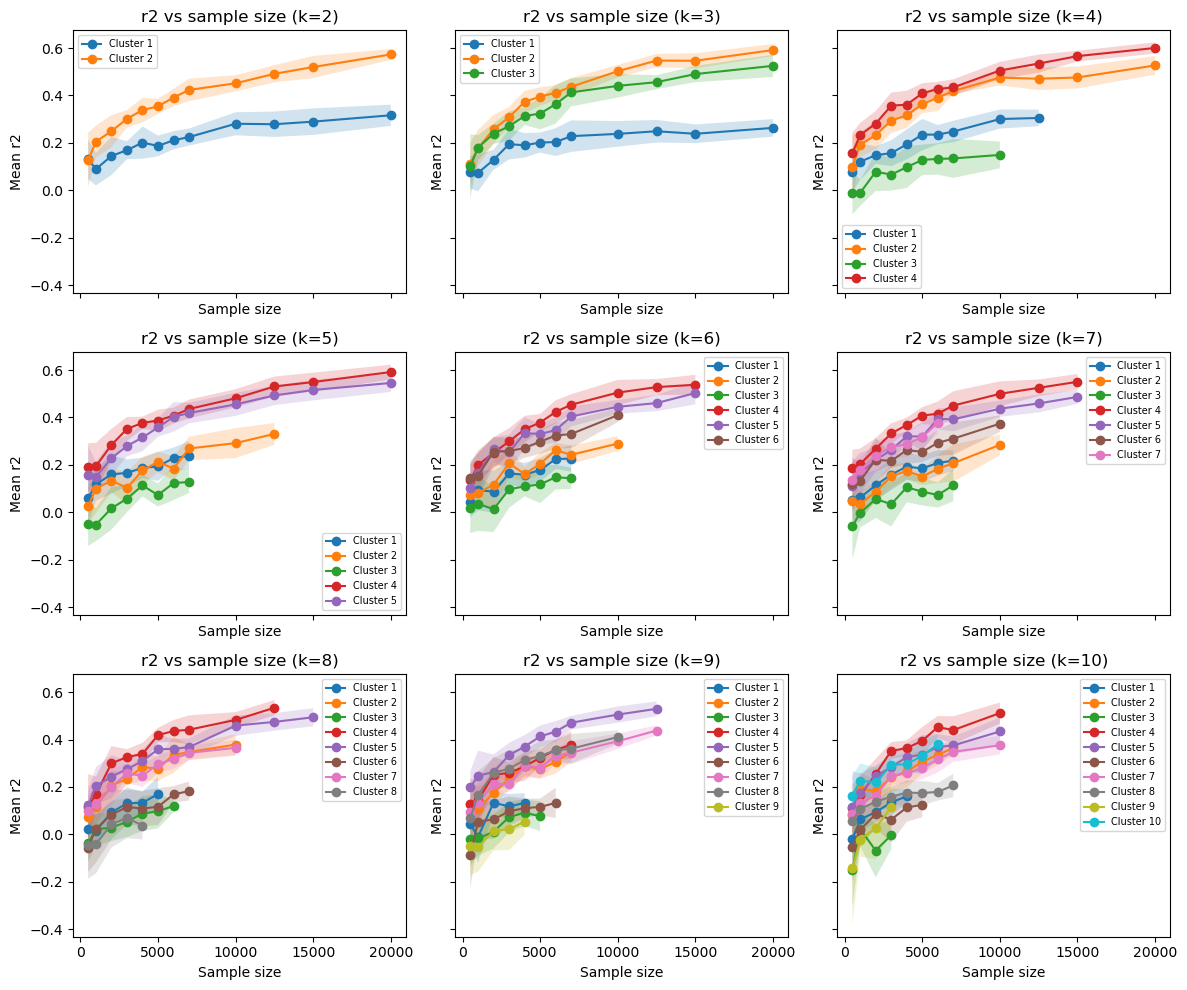

In [15]:
statistic_to_plot = "r2"

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

for ax_num, k in enumerate(range(2, 11)):

    df_k = summary[summary["k"] == k]

    for cluster_num in sorted(df_k["cluster"].unique()):

        df_c = df_k[df_k["cluster"] == cluster_num]

        axs[ax_num].plot(
            df_c["sample_size"],
            df_c[f"mean_{statistic_to_plot}"],
            marker="o",
            label=f"Cluster {cluster_num}")
        
        axs[ax_num].fill_between(
        df_c["sample_size"],
        df_c[f"mean_{statistic_to_plot}"] - df_c[f"std_{statistic_to_plot}"],
        df_c[f"mean_{statistic_to_plot}"] + df_c[f"std_{statistic_to_plot}"],
        alpha=0.2)

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel(f"Mean {statistic_to_plot}")
    axs[ax_num].set_title(f"{statistic_to_plot} vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
    
fig.tight_layout()